In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Set a random seed for reproducibility
torch.manual_seed(42)
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from differential_model import *
from generate_data import *
from physical_model import *
from plot import *

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")
device = torch.device("cpu")

GPU: NVIDIA GeForce GTX 1650 Ti


In [5]:
# Define parameters for the structural dynamics problem
ndof = 5  # Number of degrees of freedom
kvec = [95, 98, 100, 104, 97]
cvec = [0.18, 0.22, 0.24, 0.18, 0.19]
mvec = [1, 1, 1, 0.8, 0.8]

# Create an assembly matrix 'onemat'
onemat = np.array([[1, -1], [-1, 1]])

# Initialize the assembly matrix for each degree of freedom
assembly_mat = [np.zeros((ndof, ndof)) for _ in range(ndof)]
assembly_mat[0][0, 0] = 1

# Initialize Mass, Stiffness, and Damping matrices
Mass = np.diag(mvec)
Stif = np.zeros((ndof, ndof))
Damp = np.zeros((ndof, ndof))

# Assemble Stiffness and Damping matrices
for i in range(ndof):
    if i != 0:
        assembly_mat[i] = np.zeros((ndof, ndof))
        assembly_mat[i][i-1:i+1, i-1:i+1] = onemat
    Stif += kvec[i] * assembly_mat[i]
    Damp += cvec[i] * assembly_mat[i]

# Now, 'Stif' and 'Damp' matrices are assembled based on the assembly_mat and provided parameters

fs = 50
Tf = 10
tspan = torch.arange(0, Tf, 1/fs)
nt = fs * Tf

In [6]:
# Initialize the Spring_Model on the GPU
spring_model_gt = NonLinearDynamicsModel(Mass, Stif, Damp, fs, device, k3vec = [10000, 0, 0, 5000, 0], c2vec = [0, 0, 0, 0, 0])
simulator = LinearDynamicsModel(Mass, Stif, Damp, fs, device)

Current State: 1
A Shape: torch.Size([10, 10])
B Shape: torch.Size([10, 5])
A_k3 Shape: torch.Size([10, 10])
A_c2 Shape: torch.Size([10, 10])


In [7]:
# Create a neural network model
model1 = NeuralNet(11, [16, 32, 64, 32, 16], 10, nn.ReLU(), device)
model1.load_state_dict(torch.load('linear_5_dof_model_parameters_m1.pth'))
model2 = NeuralNet(11, [16, 32, 64, 32, 16], 5, nn.ReLU(), device)
model2.load_state_dict(torch.load('linear_5_dof_new_model_parameters_m1.pth'))



<All keys matched successfully>

In [8]:
sig_u_test = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.4, 6, 6.5, 7]
data_gt_test = torch.zeros(nt, len(sig_u_test), 10)
data_simulated_test = torch.zeros(nt, len(sig_u_test), 10)
data_simulated_NN_test = torch.zeros(nt, len(sig_u_test), 10)
u_data_test = torch.zeros(nt, len(sig_u_test), 5)

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], nt, fs, device)
    u_vec = torch.zeros(nt, 5).to(device)
    u_vec[:, 0] = u
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u_vec).T
    data_simulated_test[:, i, :] = generate_date(simulator, u_vec).T
    u_data_test[:, i, :] = u_vec


yi = data_simulated_NN_test[0, :].T
for m in range(nt - 1):
    u_m = u_data_test[m , :].T # torch.Size([1, 5])
    yi = simulator.step(yi, u_m)
    input = torch.cat([u_m[0:1, :], yi], axis=0).T  # Concatenate k and yi.T
    dy_i = model1(input).T # torch.Size([2, 5])
    yi = yi + dy_i
    data_simulated_NN_test[m + 1, :] = yi.T

In [9]:
data_simulated_NN_Epsilon_test = torch.zeros(nt, len(sig_u_test), 10)

yi_epsilon = data_simulated_NN_test[0, :].T
for m in range(nt - 1):
    u_m = u_data_test[m , :].T # torch.Size([1, 5])
    yi_epsilon = simulator.step(yi_epsilon, u_m)
    input = torch.cat([u_m[0:1, :], yi_epsilon], axis=0).T  # Concatenate k and yi.T
    epsilon = model2(input).T # torch.Size([2, 5])
    dy_i = simulator.step_model(epsilon)
    yi_epsilon = yi_epsilon + dy_i
    data_simulated_NN_Epsilon_test[m + 1, :] = yi_epsilon.T

In [10]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
final_epsilon_error_test = torch.mean((data_gt_test -data_simulated_NN_Epsilon_test) ** 2)
initial_error_test, final_error_test, final_epsilon_error_test

(tensor(0.0538),
 tensor(0.0189, grad_fn=<MeanBackward0>),
 tensor(0.0044, grad_fn=<MeanBackward0>))

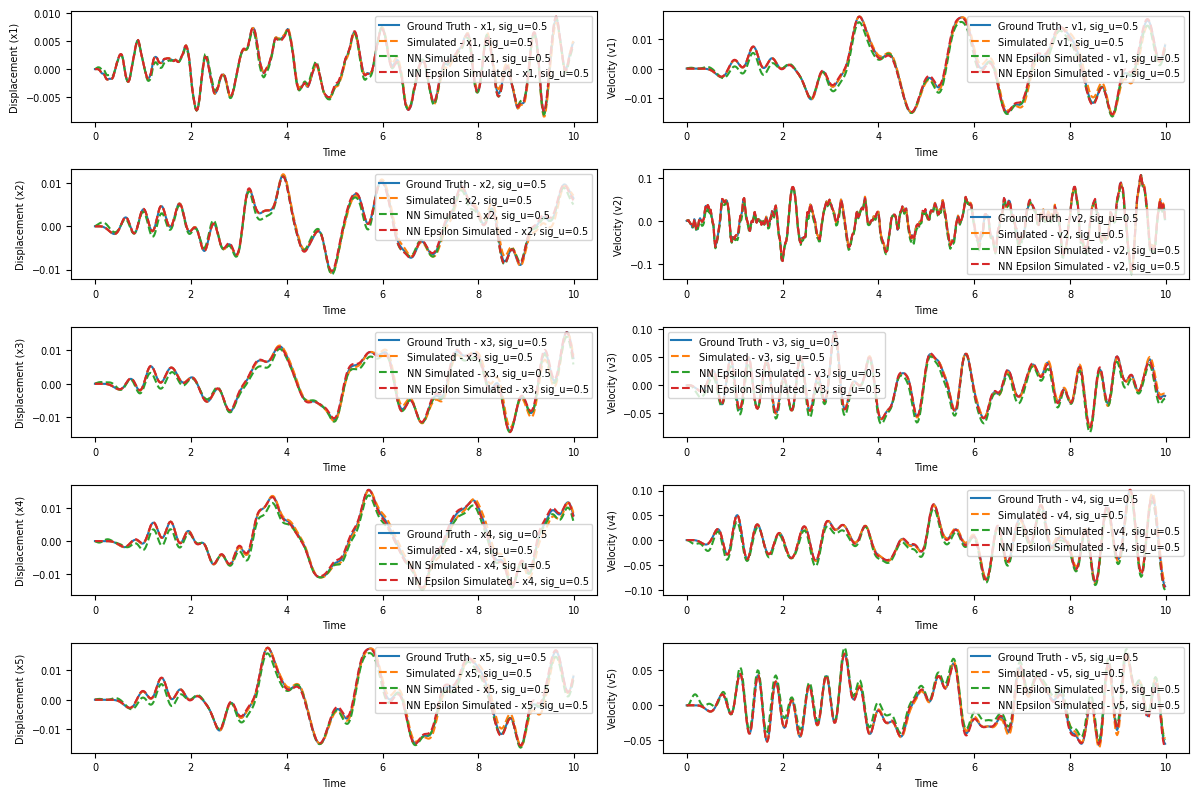

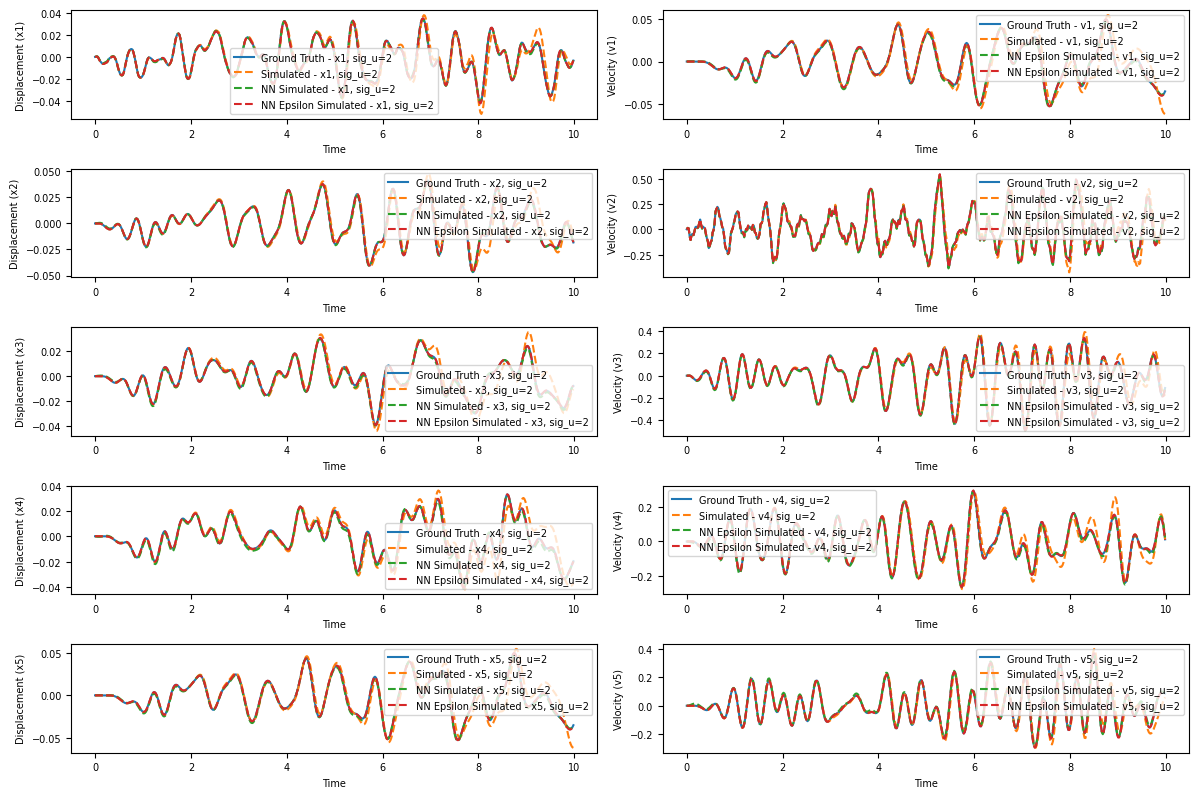

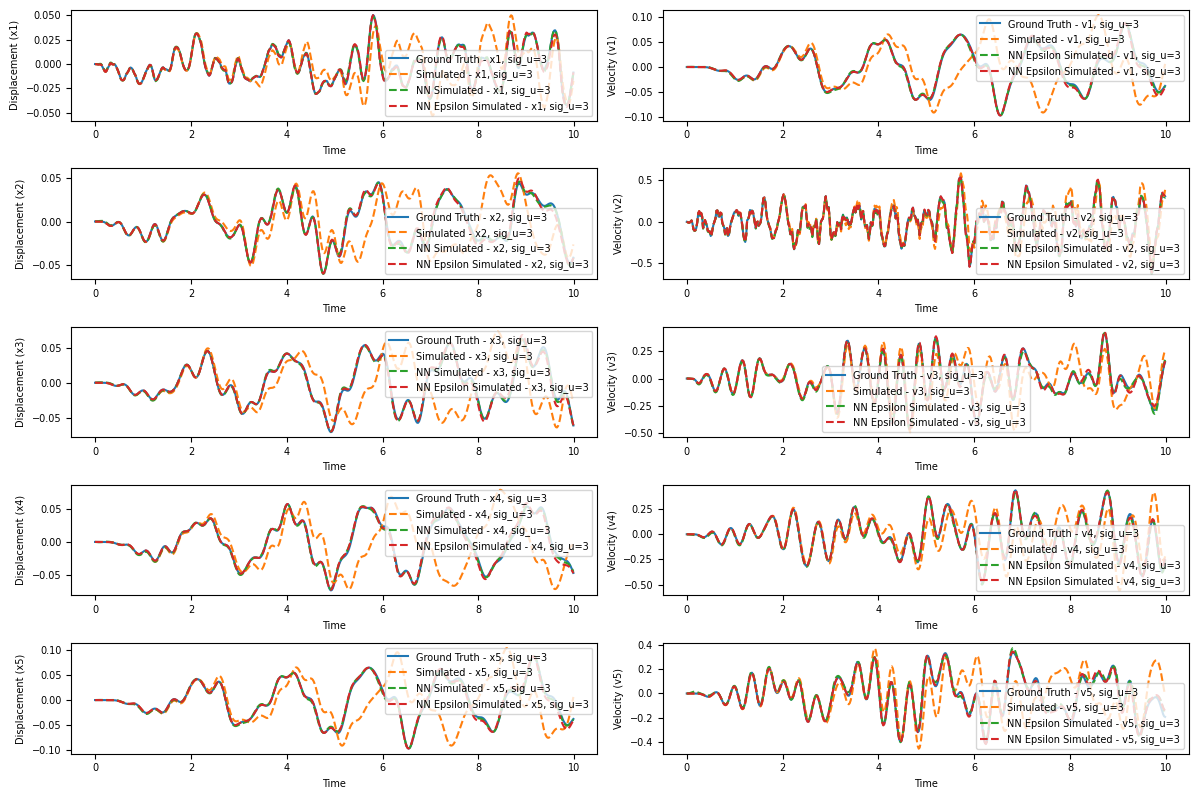

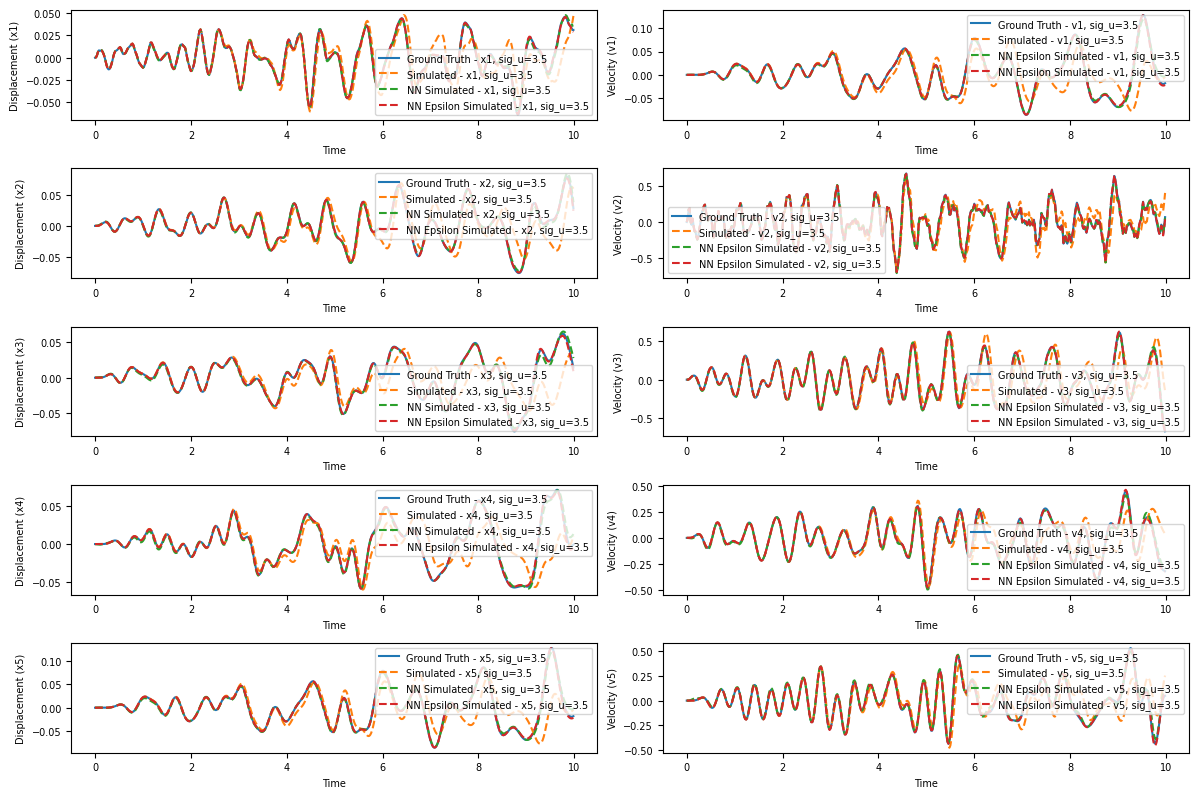

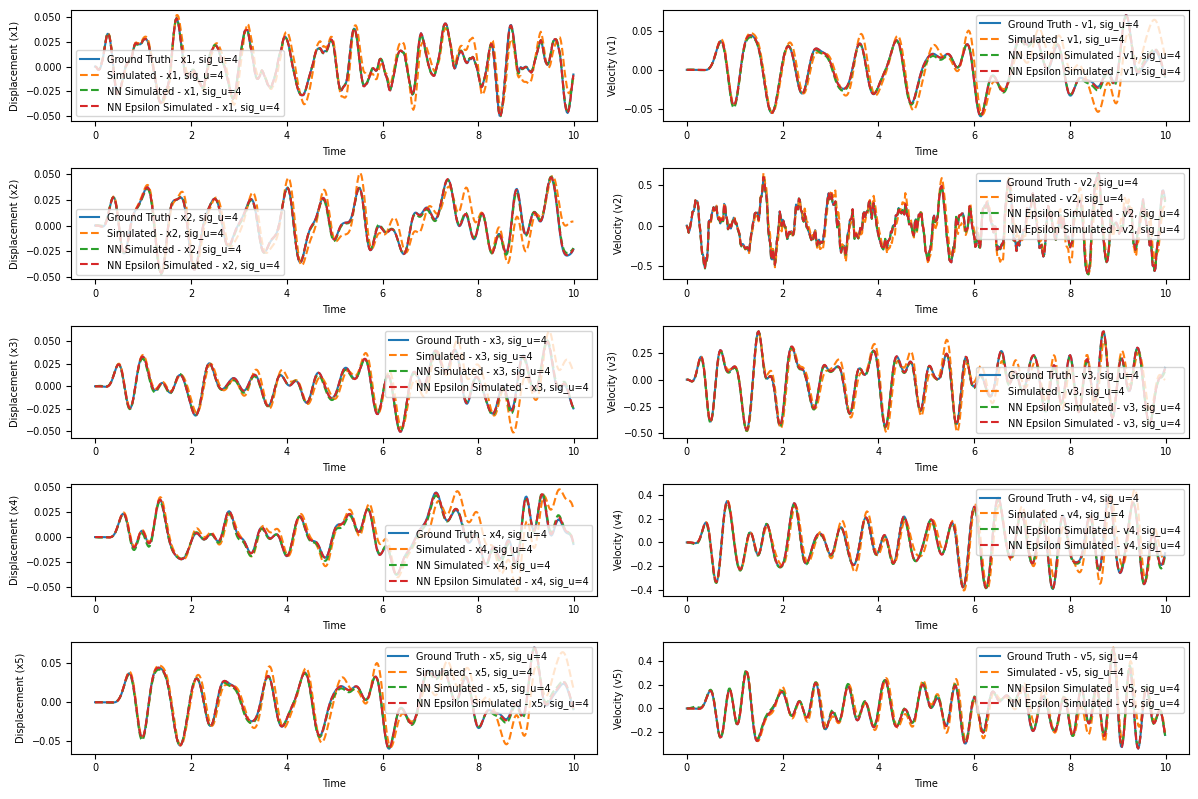

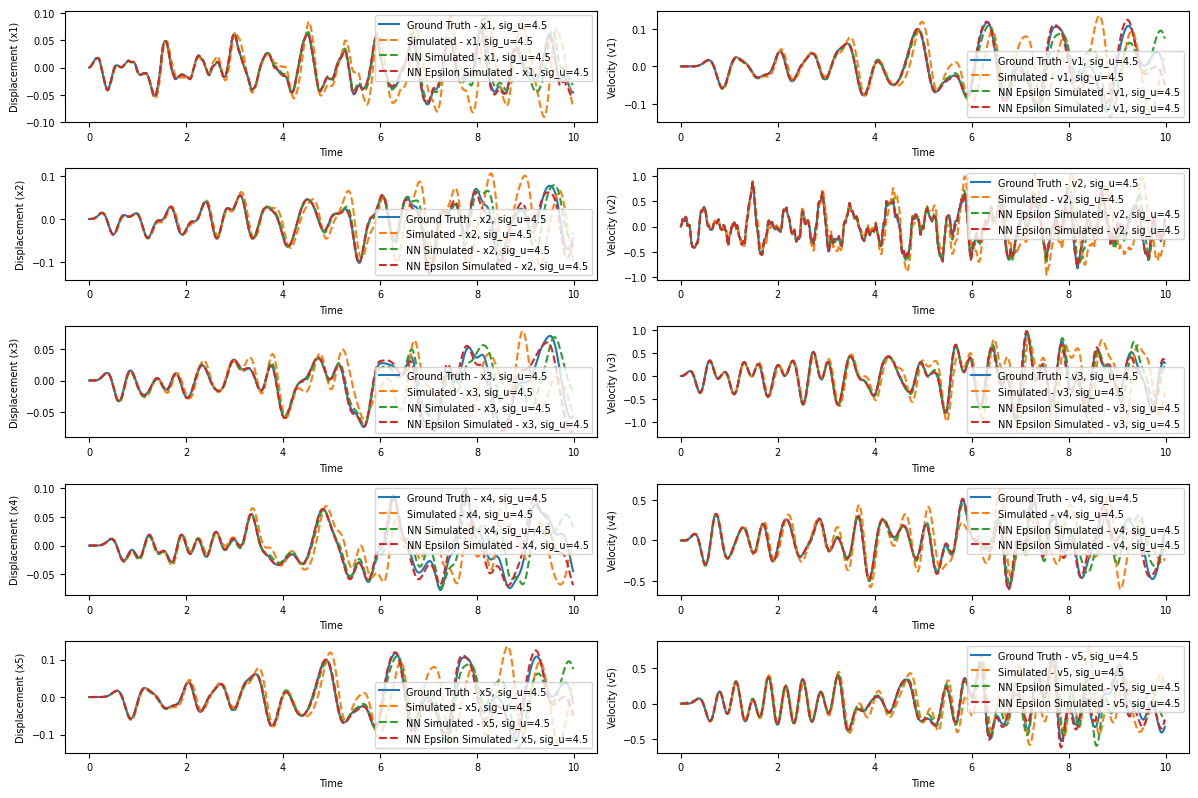

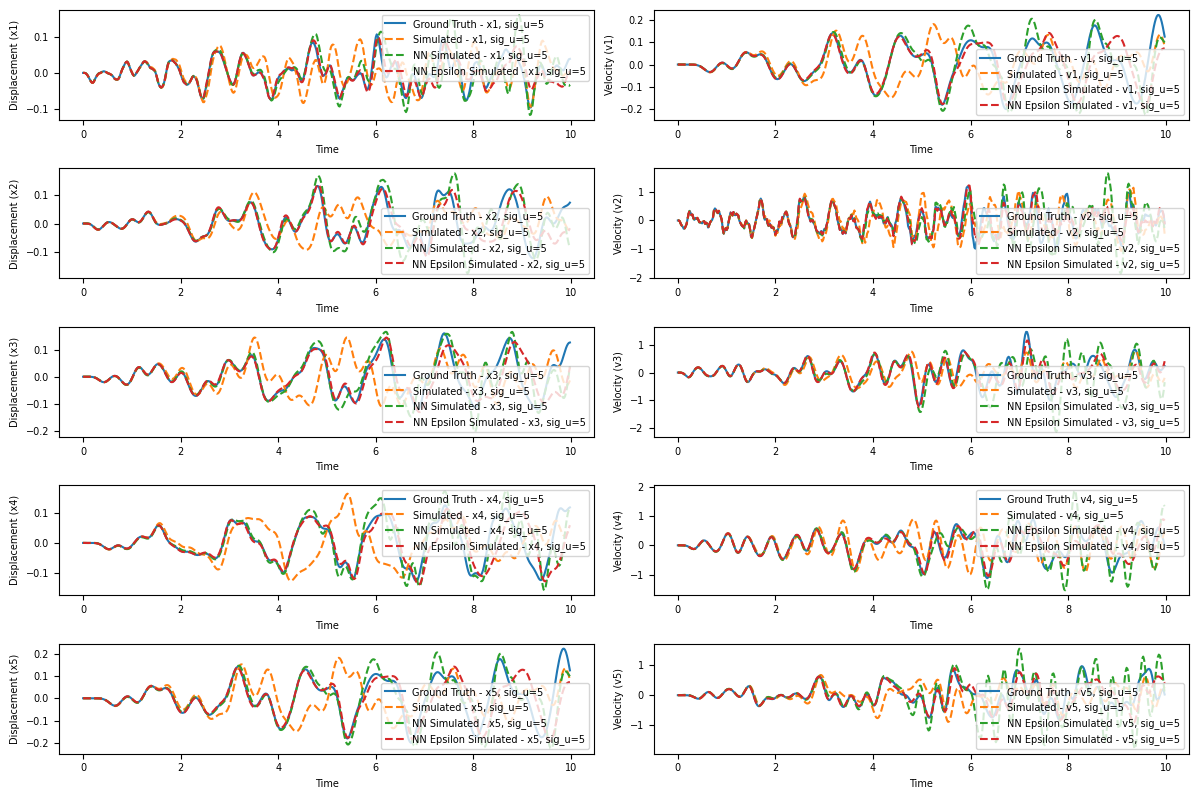

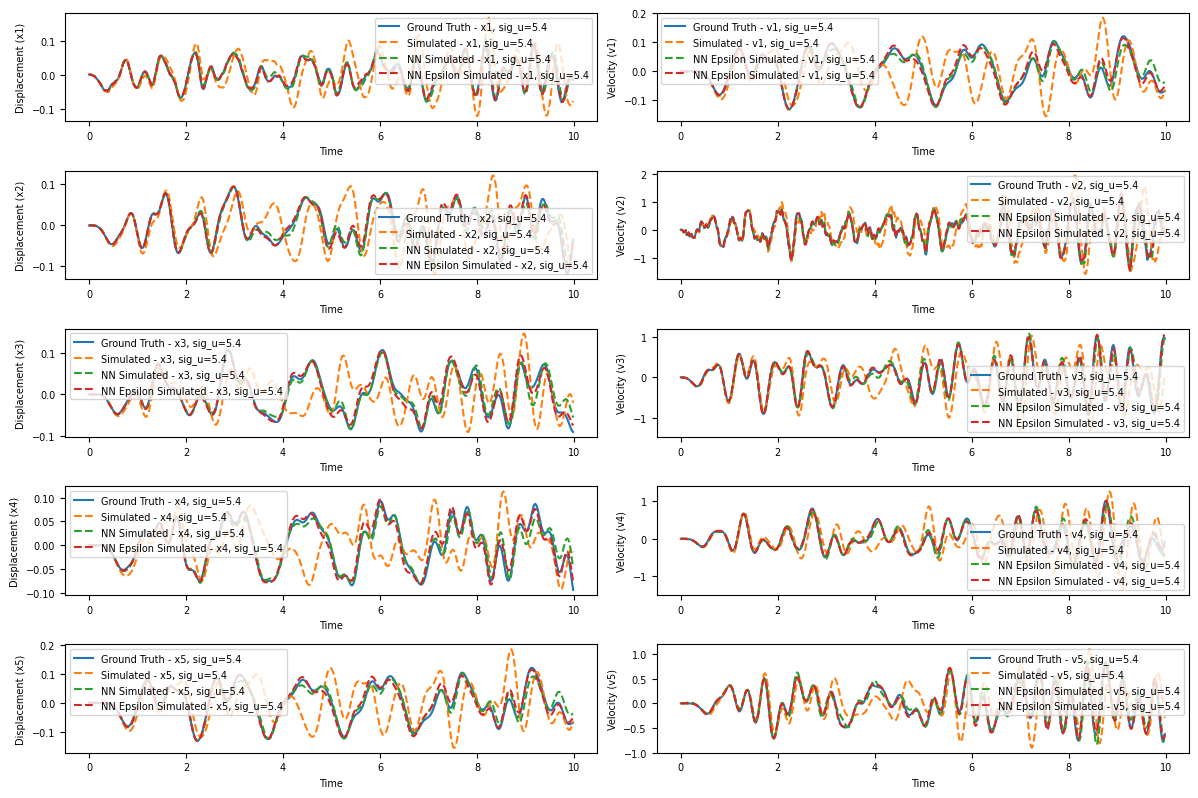

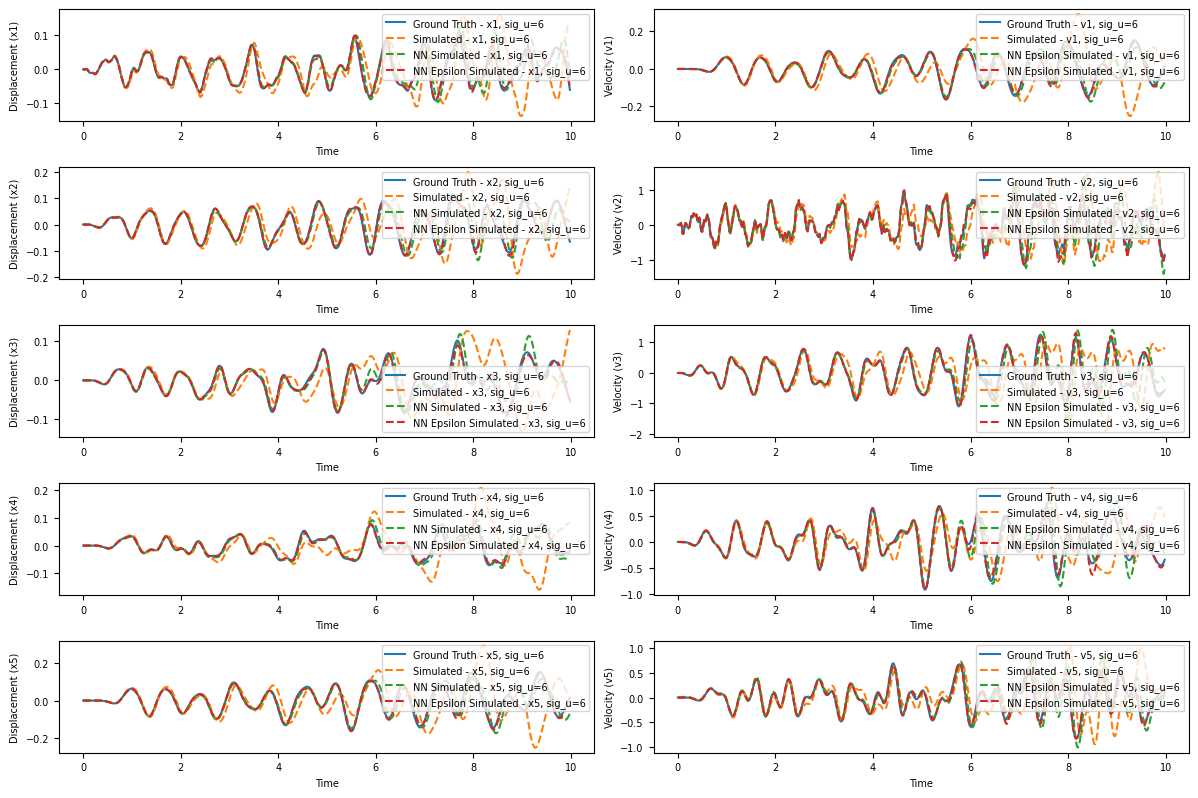

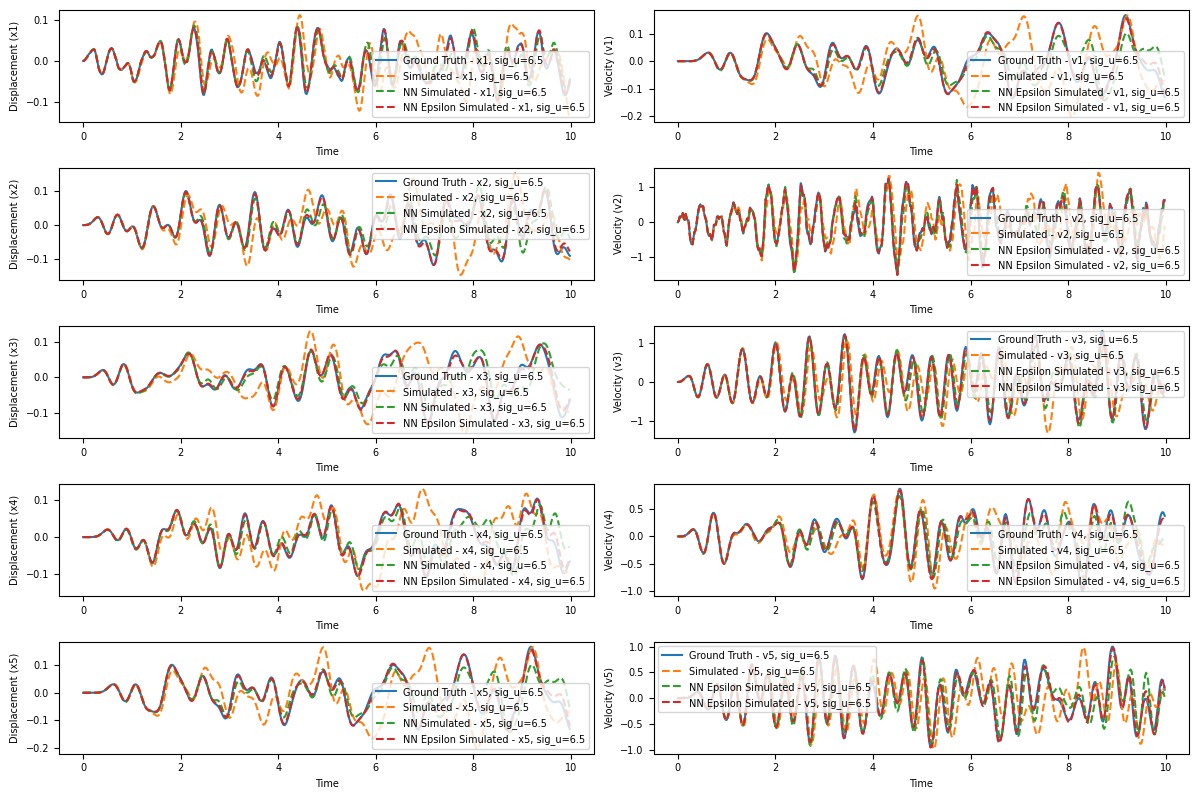

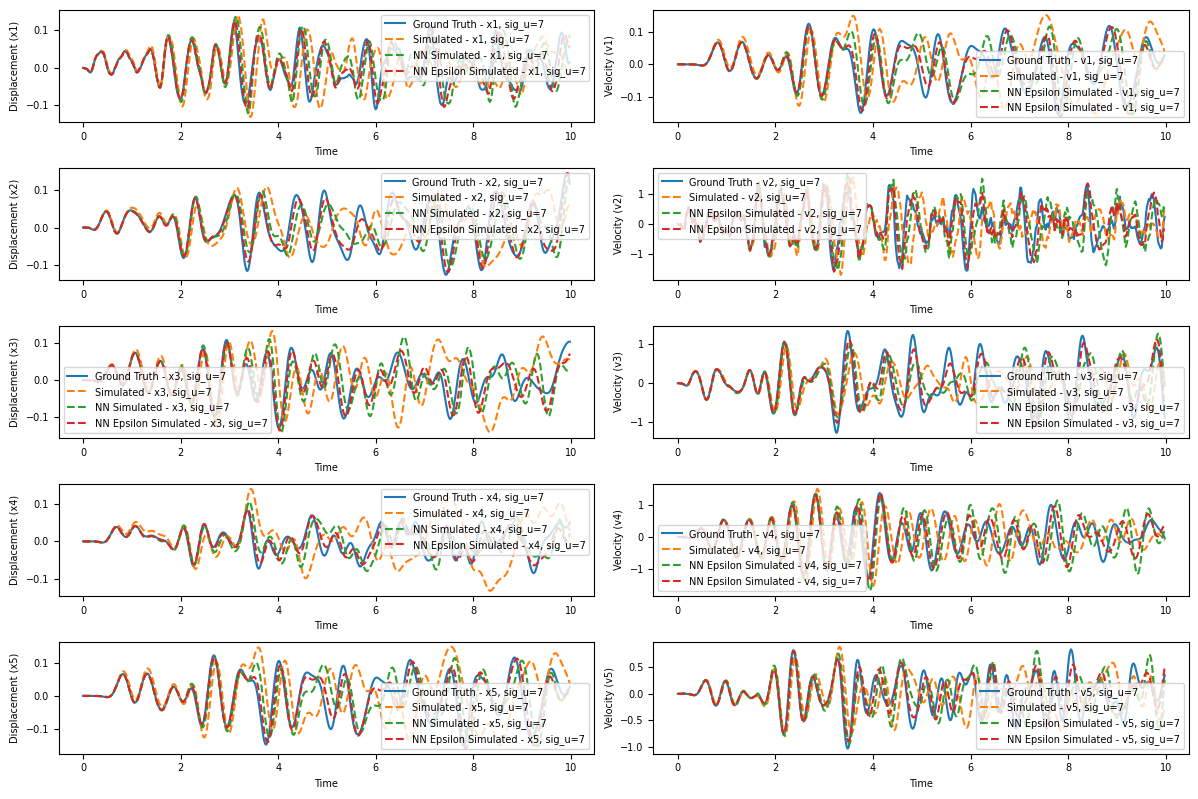

In [11]:
time_values = tspan.squeeze().cpu().numpy()
plt.rcParams.update({'font.size': 7})

for i in range(len(sig_u_test)):
    plt.figure(figsize=(12, 8))

    # Plotting for each degree of freedom
    for j in range(ndof):
        plt.subplot(ndof, 2, 2*j+1)  # For displacement (x)
        plt.plot(time_values, data_gt_test[:, i, j], label=f'Ground Truth - x{ j + 1 }, sig_u={sig_u_test[i]}')
        plt.plot(time_values, data_simulated_test[:, i, j], label=f'Simulated - x{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, j], label=f'NN Simulated - x{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN_Epsilon_test.detach().numpy()[:, i, j], label=f'NN Epsilon Simulated - x{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='--')

        plt.xlabel('Time')
        plt.ylabel(f'Displacement (x{ j + 1 })')
        plt.legend()

        plt.subplot(ndof, 2, 2*j+2)  # For velocity (v)
        plt.plot(time_values, data_gt_test[:, i, j + 4], label=f'Ground Truth - v{ j + 1 }, sig_u={sig_u_test[i]}')
        plt.plot(time_values, data_simulated_test[:, i, j + 4], label=f'Simulated - v{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, j + 4], label=f'NN Epsilon Simulated - v{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='dashed')
        plt.plot(time_values, data_simulated_NN_Epsilon_test.detach().numpy()[:, i, j + 4], label=f'NN Epsilon Simulated - v{ j + 1 }, sig_u={sig_u_test[i]}', linestyle='--')

        plt.xlabel('Time')
        plt.ylabel(f'Velocity (v{ j + 1 })')
        plt.legend()

    plt.tight_layout()
    plt.show()